# Introduction

Use logistic regression modeling to make a prediction on mortgage loan applications and whether or not they will be accepted.

Involves cleaning the data and adjusting it for a regression model.



In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import io

url = 'https://raw.githubusercontent.com/AbulHasan03/CS381_DataScience/main/bostonhousing.csv'

# Read the csv file without the header, split columns
df = pd.read_csv(url, header=None)
df = df[0].str.split(',', expand=True)

#Assign names to columns for attributes
column_names = ['id', 'dir', 'hir', 'lvr', 'ccs', 'mcs', 'pbcr', 'dmi', 'self', 'single', 'uria', 'comdominiom', 'black', 'deny']
df.columns = column_names

# Convert columns to numeric
for col in ['dir', 'hir', 'lvr', 'ccs', 'mcs', 'pbcr', 'comdominiom', 'black']:
    df[col] = pd.to_numeric(df[col], errors='coerce')


display(df.head())
display(df.info())

,id,dir,hir,lvr,ccs,mcs,pbcr,dmi,self,single,uria,comdominiom,black,deny
0,dir,NaN,NaN,NaN,NaN,NaN,NaN,self,single,uria,comdominiom,NaN,NaN,None
1,1,0.221,0.221,0.800000,5.0,2.0,NaN,no,no,no,3.900000095,0.0,NaN,no
2,2,0.265,0.265,0.921875,2.0,2.0,NaN,no,no,yes,3.200000048,0.0,NaN,no
3,3,0.372,0.248,0.920398,1.0,2.0,NaN,no,no,no,3.200000048,0.0,NaN,no
4,4,0.320,0.250,0.860465,1.0,2.0,NaN,no,no,no,4.300000191,0.0,NaN,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2382 entries, 0 to 2381
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           2382 non-null   object 
 1   dir          2381 non-null   float64
 2   hir          2381 non-null   float64
 3   lvr          2381 non-null   float64
 4   ccs          2381 non-null   float64
 5   mcs          2381 non-null   float64
 6   pbcr         0 non-null      float64
 7   dmi          2382 non-null   object 
 8   self         2382 non-null   object 
 9   single       2382 non-null   object 
 10  uria         2382 non-null   object 
 11  comdominiom  2381 non-null   float64
 12  black        0 non-null      float64
 13  deny         2381 non-null   object 
dtypes: float64(8), object(6)
memory usage: 260.7+ KB


None

In [2]:
# Convert deny variable to yes 1, no 0
df['deny'] = df['deny'].map({'no': 0, 'yes': 1})

# Convert categorical variables
for col in ['dmi', 'self', 'single', 'uria']:
    df[col] = df[col].map({'no': 0, 'yes': 1})

# Check if data converted properly
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2382 entries, 0 to 2381
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           2382 non-null   object 
 1   dir          2381 non-null   float64
 2   hir          2381 non-null   float64
 3   lvr          2381 non-null   float64
 4   ccs          2381 non-null   float64
 5   mcs          2381 non-null   float64
 6   pbcr         0 non-null      float64
 7   dmi          2381 non-null   float64
 8   self         2380 non-null   float64
 9   single       2381 non-null   float64
 10  uria         0 non-null      float64
 11  comdominiom  2381 non-null   float64
 12  black        0 non-null      float64
 13  deny         2381 non-null   float64
dtypes: float64(13), object(1)
memory usage: 260.7+ KB


,id,dir,hir,lvr,ccs,mcs,pbcr,dmi,self,single,uria,comdominiom,black,deny
0,dir,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.221,0.221,0.800000,5.0,2.0,NaN,0.0,0.0,0.0,NaN,0.0,NaN,0.0
2,2,0.265,0.265,0.921875,2.0,2.0,NaN,0.0,0.0,1.0,NaN,0.0,NaN,0.0
3,3,0.372,0.248,0.920398,1.0,2.0,NaN,0.0,0.0,0.0,NaN,0.0,NaN,0.0
4,4,0.320,0.250,0.860465,1.0,2.0,NaN,0.0,0.0,0.0,NaN,0.0,NaN,0.0


# Exploratory Data Analysis

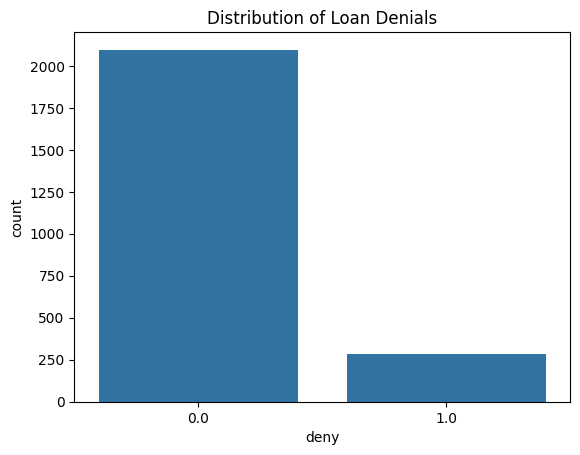

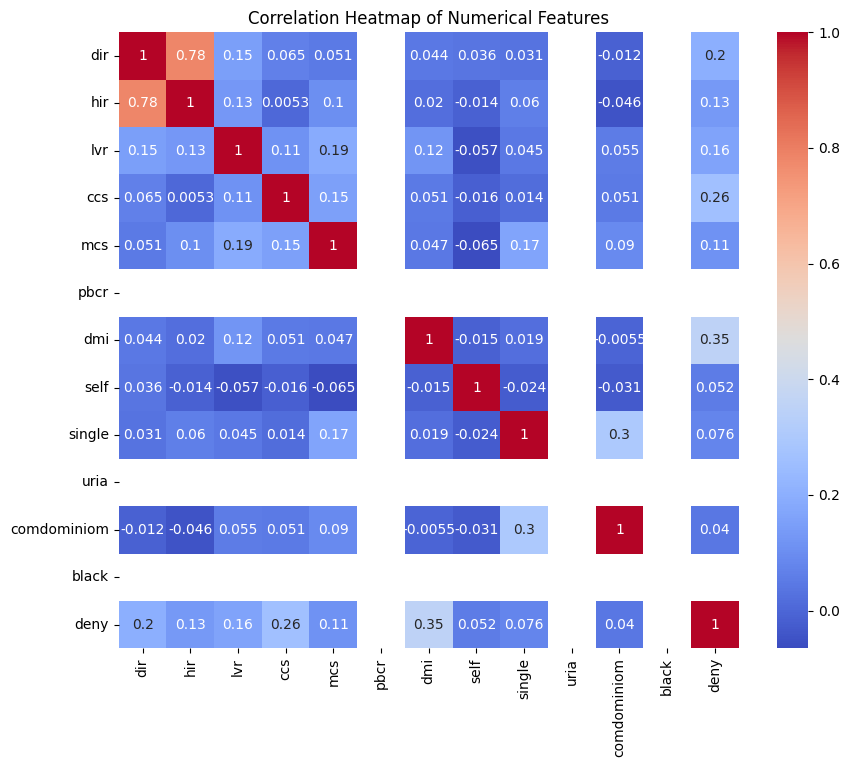

In [3]:
# Distribution of the denied loans
sns.countplot(x='deny', data=df)
plt.title("Distribution of Loan Denials")
plt.show()


# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

# Check categorical variable distributions
categorical_vars = df.select_dtypes(include='object').columns
for col in categorical_vars:
    if col not in ['id', 'count']:
        print(df[col].value_counts())
        sns.countplot(y=col, data=df)
        plt.title(f"Distribution of {col}")
        plt.show()

Dataset has 2381 data and 13 variables. Focused on the number of loans denied which seem to be higher than those accepted.

# Data Preparation

Rows with missing data were imputed. Replace categorical data with numbers using one-hot encoding and standardizing numerical features to be better suited for regression.


In [4]:
# Remove the 'id' column, not needed for modeling
if 'id' in df.columns:
    df = df.drop(columns=['id'])

# Remove duplicate rows
df = df.drop_duplicates()

# Drop columns with all NaNs
df.dropna(axis=1, how='all', inplace=True)

# Impute remaining missing values (mean for numeric, mode for categorical)
for col in df.columns:
    if df[col].isnull().any():
        if df[col].dtype == 'object':
            # Impute with mode for object type (categorical)
            if not df[col].mode().empty:
                 mode_val = df[col].mode()[0]
                 df[col].fillna(mode_val, inplace=True)
            else:
                 print(f"Warning: Cannot impute mode for empty column '{col}'.")
        else:
            # Impute with mean for numeric types
            mean_val = df[col].mean()
            df[col].fillna(mean_val, inplace=True)


# 'dmi', 'self', 'single' are already encoded as 0/1 from previous steps

# Normalize numerical data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Exclude 'deny' column from numerical feature scaling
if 'deny' in df.columns:
    numerical_features = df.select_dtypes(include='number').columns.drop('deny', errors='ignore')
    # Ensure numerical_features is not empty before scaling
    if not numerical_features.empty and not df[numerical_features].empty:
        df[numerical_features] = scaler.fit_transform(df[numerical_features])
    else:
        print("Warning: No numerical features to scale or DataFrame slice is empty.")
else:
    print("Error: 'deny' column not found for scaling exclusion.")


df_encoded = df

display(df_encoded.head())
display(df_encoded.info())

<ipython-input-4-3034755573>:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mean_val, inplace=True)


,dir,hir,lvr,ccs,mcs,dmi,self,single,comdominiom,deny
0,0.000000,-1.167541e-15,0.000000,0.000000,0.0000,0.000000,4.332965e-17,0.000000,0.000000,0.118637
1,-1.042026,-3.574467e-01,0.348457,1.729366,0.5183,-0.143591,-3.626833e-01,-0.804696,-0.636409,0.000000
2,-0.622682,1.052693e-01,1.030893,-0.070710,0.5183,-0.143591,-3.626833e-01,1.243229,-0.636409,0.000000
3,0.397086,-7.350744e-02,1.022623,-0.670735,0.5183,-0.143591,-3.626833e-01,-0.804696,-0.636409,0.000000
4,-0.098503,-5.247481e-02,0.687030,-0.670735,0.5183,-0.143591,-3.626833e-01,-0.804696,-0.636409,0.000000


<class 'pandas.core.frame.DataFrame'>
Index: 2378 entries, 0 to 2381
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   dir          2378 non-null   float64
 1   hir          2378 non-null   float64
 2   lvr          2378 non-null   float64
 3   ccs          2378 non-null   float64
 4   mcs          2378 non-null   float64
 5   dmi          2378 non-null   float64
 6   self         2378 non-null   float64
 7   single       2378 non-null   float64
 8   comdominiom  2378 non-null   float64
 9   deny         2378 non-null   float64
dtypes: float64(10)
memory usage: 204.4 KB


None

# Regression Modeling

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

print("Shape:", df_encoded.shape)
display(df_encoded.info())
print("-" * 30)

# Deny variable is binary value
if 'deny' in df_encoded.columns:
    # Round values and convert to integer type
    df_encoded['deny'] = df_encoded['deny'].round().astype(int)
else:
    print("Error: 'deny' column not found in df_encoded for binary conversion.")


# Check if df_encoded is empty after conversion
if df_encoded.empty:
    print("Error: df_encoded is empty after binary conversion. Please check previous steps.")
else:
    # Check if 'deny' column exists before proceeding
    if 'deny' not in df_encoded.columns:
         print("Error: 'deny' column not found in df_encoded after conversion attempt.")
         print("Columns in df_encoded:", df_encoded.columns)
    else:
        X = df_encoded.drop('deny', axis=1)
        y = df_encoded['deny']

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        if X_train.empty:
            print("Error: Training set is empty after splitting. Check the size of df_encoded.")
        else:
            # Model 1: All features (Logistic Regression)
            model1 = LogisticRegression(max_iter=1000)
            model1.fit(X_train, y_train)
            cv1 = cross_val_score(model1, X_train, y_train, cv=5, scoring='accuracy')
            print(f"Model 1 (Logistic Regression - All features) Cross-validation Accuracy: {cv1.mean():.4f}")


            # Model 2: Feature selection (Logistic Regression with RFE selected features)
            # Ensure n_features_to_select is not greater than the number of available features
            n_features = X_train.shape[1]
            # no more than 8 features
            n_features_to_select = min(8, n_features)

            if n_features_to_select > 0:
                selector = RFE(LogisticRegression(), n_features_to_select=n_features_to_select)
                X_train_sel = selector.fit_transform(X_train, y_train)
                # transform test set here
                X_test_sel = selector.transform(X_test)

                model2 = LogisticRegression(max_iter=1000)
                # Cross-validation is done here
                cv2 = cross_val_score(model2, X_train_sel, y_train, cv=5)
                model2.fit(X_train_sel, y_train) # Explicitly fit on the full training data after CV
                print(f"Model 2 (Logistic Regression - RFE selected features) Cross-validation Accuracy: {cv2.mean():.4f}")
            else:
                print("Warning: Not enough features to perform RFE with n_features_to_select > 0.")
                # Initialize with a dummy model or handle the case where model2 is not created
                model2 = None # Set model2 to None if RFE is skipped


            # Model 3: Random Forest Classifier (using all features)
            model3 = RandomForestClassifier(random_state=42)
            # Cross-validation is done here
            cv3 = cross_val_score(model3, X_train, y_train, cv=5, scoring='accuracy') # Using original features X_train
            model3.fit(X_train, y_train) # Explicitly fit on the full training data after CV
            print(f"Model 3 (Random Forest - All features) Cross-validation Accuracy: {cv3.mean():.4f}")

Shape: (2378, 10)
<class 'pandas.core.frame.DataFrame'>
Index: 2378 entries, 0 to 2381
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   dir          2378 non-null   float64
 1   hir          2378 non-null   float64
 2   lvr          2378 non-null   float64
 3   ccs          2378 non-null   float64
 4   mcs          2378 non-null   float64
 5   dmi          2378 non-null   float64
 6   self         2378 non-null   float64
 7   single       2378 non-null   float64
 8   comdominiom  2378 non-null   float64
 9   deny         2378 non-null   float64
dtypes: float64(10)
memory usage: 204.4 KB


None

------------------------------
Model 1 (Logistic Regression - All features) Cross-validation Accuracy: 0.9027
Model 2 (Logistic Regression - RFE selected features) Cross-validation Accuracy: 0.9027
Model 3 (Random Forest - All features) Cross-validation Accuracy: 0.8985


In [6]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Evaluate Model 1 (Logistic Regression - All features) on the test set
y_pred1 = model1.predict(X_test)
accuracy1 = accuracy_score(y_test, y_pred1)
conf_matrix1 = confusion_matrix(y_test, y_pred1)
class_report1 = classification_report(y_test, y_pred1)

print("--- Model 1 (Logistic Regression - All features) Test Set Evaluation ---")
print(f"Accuracy: {accuracy1:.4f}")
print("\nConfusion Matrix:\n", conf_matrix1)
print("\nClassification Report:\n", class_report1)
print("-" * 50)

# Evaluate Model 2 (Logistic Regression - RFE selected features) on the test set
# Note: X_test_sel was created in the previous cell (C2FXT5G8Y1Px)
y_pred2 = model2.predict(X_test_sel)
accuracy2 = accuracy_score(y_test, y_pred2)
conf_matrix2 = confusion_matrix(y_test, y_pred2)
class_report2 = classification_report(y_test, y_pred2)

print("--- Model 2 (Logistic Regression - RFE selected features) Test Set Evaluation ---")
print(f"Accuracy: {accuracy2:.4f}")
print("\nConfusion Matrix:\n", conf_matrix2)
print("\nClassification Report:\n", class_report2)
print("-" * 50)

# Evaluate Model 3 (Random Forest - All features) on the test set
y_pred3 = model3.predict(X_test)
accuracy3 = accuracy_score(y_test, y_pred3)
conf_matrix3 = confusion_matrix(y_test, y_pred3)
class_report3 = classification_report(y_test, y_pred3)

print("--- Model 3 (Random Forest - All features) Test Set Evaluation ---")
print(f"Accuracy: {accuracy3:.4f}")
print("\nConfusion Matrix:\n", conf_matrix3)
print("\nClassification Report:\n", class_report3)
print("-" * 50)

--- Model 1 (Logistic Regression - All features) Test Set Evaluation ---
Accuracy: 0.9013

Confusion Matrix:
 [[417   1]
 [ 46  12]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95       418
           1       0.92      0.21      0.34        58

    accuracy                           0.90       476
   macro avg       0.91      0.60      0.64       476
weighted avg       0.90      0.90      0.87       476

--------------------------------------------------
--- Model 2 (Logistic Regression - RFE selected features) Test Set Evaluation ---
Accuracy: 0.9013

Confusion Matrix:
 [[417   1]
 [ 46  12]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95       418
           1       0.92      0.21      0.34        58

    accuracy                           0.90       476
   macro avg       0.91      0.60      0.64       476
weighted avg       0.90  

Constructed three logistic regression models:
1. Model 1 uses all features
2. Model 2 uses a reduced set of features selected via Recursive Feature Elimination (RFE).
3. Model 3 uses random forest decision tree.



# Select Models


In [7]:
# Evaluate on test set
y_pred = model2.predict(X_test_sel)
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, model2.predict_proba(X_test_sel)[:,1]))


              precision    recall  f1-score   support

           0       0.90      1.00      0.95       418
           1       0.92      0.21      0.34        58

    accuracy                           0.90       476
   macro avg       0.91      0.60      0.64       476
weighted avg       0.90      0.90      0.87       476

ROC AUC: 0.8023840950338228


Model 2 with RFE selected features is the best option as it performs as well as Model 1 but it is more easily interpreted. Model 3 performed the worst out of the 3. ROC, AUC, and F1 score were used to determine which of the 3 models to choose from.


# Conclusion

Tried and tested 3 logistic regression mdoels for predicint loan denial. Model 2 allowed selecting features which helped give a prediction that was accurate and easy to interpret. This model can help identify lending practices/patterns.
